<a href="https://colab.research.google.com/github/Leandr0SmS/mvp_url_checker/blob/main/phishing_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# URL Check

### Contexto

Phishing é uma forma comum de crime cibernético que direciona a vítima para um endereço URL aparentemente confiável, no qual a mesma informa dados sensíveis.

### Objetivo

Esse MVP pretende buscar padrões em URLs maliciosos e classificar novos possíveis ataques.

<br/>

In [3]:
import warnings
warnings.filterwarnings("ignore")

# Imports necessários
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.metrics import classification_report
import joblib

## Carga do Dataset

Após importar as dependências, importei o dataset com urls legítimos e maliciosos.

Com a biblioteca Pandas:

- Fiz a conversão do csv para um dataFrame;
- Chamei o método .shape para saber o número de colunas e linhas.
- Com o método head é possível visualizar um resumo dos dados.

In [4]:
# URL de importação do dataset
url = "https://raw.githubusercontent.com/Leandr0SmS/mvp_url_checker/main/dataset_phishing.csv"

# Lê o arquivo
dataset = pd.read_csv(url, delimiter=',')

# Tamanho do dataset
shape = dataset.shape
print(f"lines: {shape[0]}, col: {shape[1]}")

dataset.head()


lines: 11430, col: 18


,url,length_url,length_hostname,nb_dots,nb_hyphens,nb_underscore,nb_tilde,nb_percent,nb_slash,nb_colon,nb_comma,nb_semicolumn,nb_dollar,nb_space,nb_www,nb_com,http_in_path,status
0,http://www.crestonwood.com/router.php,37,19,3,0,0,0,0,3,1,0,0,0,0,1,0,0,legitimate
1,http://shadetreetechnology.com/V4/validation/a...,77,23,1,0,0,0,0,5,1,0,0,0,0,0,0,0,phishing
2,https://support-appleld.com.secureupdate.duila...,126,50,4,1,2,0,0,5,1,0,0,0,0,0,1,0,phishing
3,http://rgipt.ac.in,18,11,2,0,0,0,0,2,1,0,0,0,0,0,0,0,legitimate
4,http://www.iracing.com/tracks/gateway-motorspo...,55,15,2,2,0,0,0,5,1,0,0,0,0,1,0,0,legitimate


## Separação dos dados

Inicialmente é definido o tamanho do conjunto de teste para 20%.

É definida a semente (seed) para embaralhar aleatoriamente as amostras de cada classe antes de dividir.

A divisão do dataFrame em entrada (X) e saída(y) é feita com base no método .shape carregado anteriormente.

O método train_test_split divide o modelo em treino e teste com estratificação indicado pelo parametro stratify=y, garantindo que a proporção de classes nos conjuntos divididos sejam aproximadamente iguais à proporção de classes no conjunto de dados original.

O método StratifiedKFold faz a validação cruzada. Selecionei o 20 partições visto que o dataset possui um número elevado de dados.


In [5]:
test_size = 0.20 # tamanho do conjunto de teste
seed = 7 # semente aleatória
dateSet_len = shape[1] - 1 # Numero de colunas do dataset

# Separação em conjuntos de treino e teste
array = dataset.values

X = array[:,1:dateSet_len]
y = array[:,dateSet_len]


X_train, X_test, y_train, y_test = train_test_split(X, y,
    test_size=test_size, shuffle=True, random_state=seed, stratify=y) # holdout com estratificação

# Parâmetros e partições da validação cruzada
scoring = 'accuracy'
num_particoes = 20
kfold = StratifiedKFold(n_splits=num_particoes, shuffle=True, random_state=seed) # validação cruzada com estratificação

## Criação e avaliação de modelos

É criada uma lista de modelos com os algorítimos de classificação:
- Arvore de Decisão (CART)
- k-nearest neighbors (KNN)
- Naive Bayes (NB)
- Máquina de vetores de suporte (SVM)

É testado cada algorítimo com os dados de treino. Os valores são plotados no gráfico para comparar os modelos com base na acurácia.

Neste primeiro teste o CART obteve o melhor resultado 0.819776 (0.011875)

KNN: 0.813869 (0.016112)
CART: 0.819776 (0.011875)
NB: 0.602799 (0.019300)
SVM: 0.734249 (0.023652)


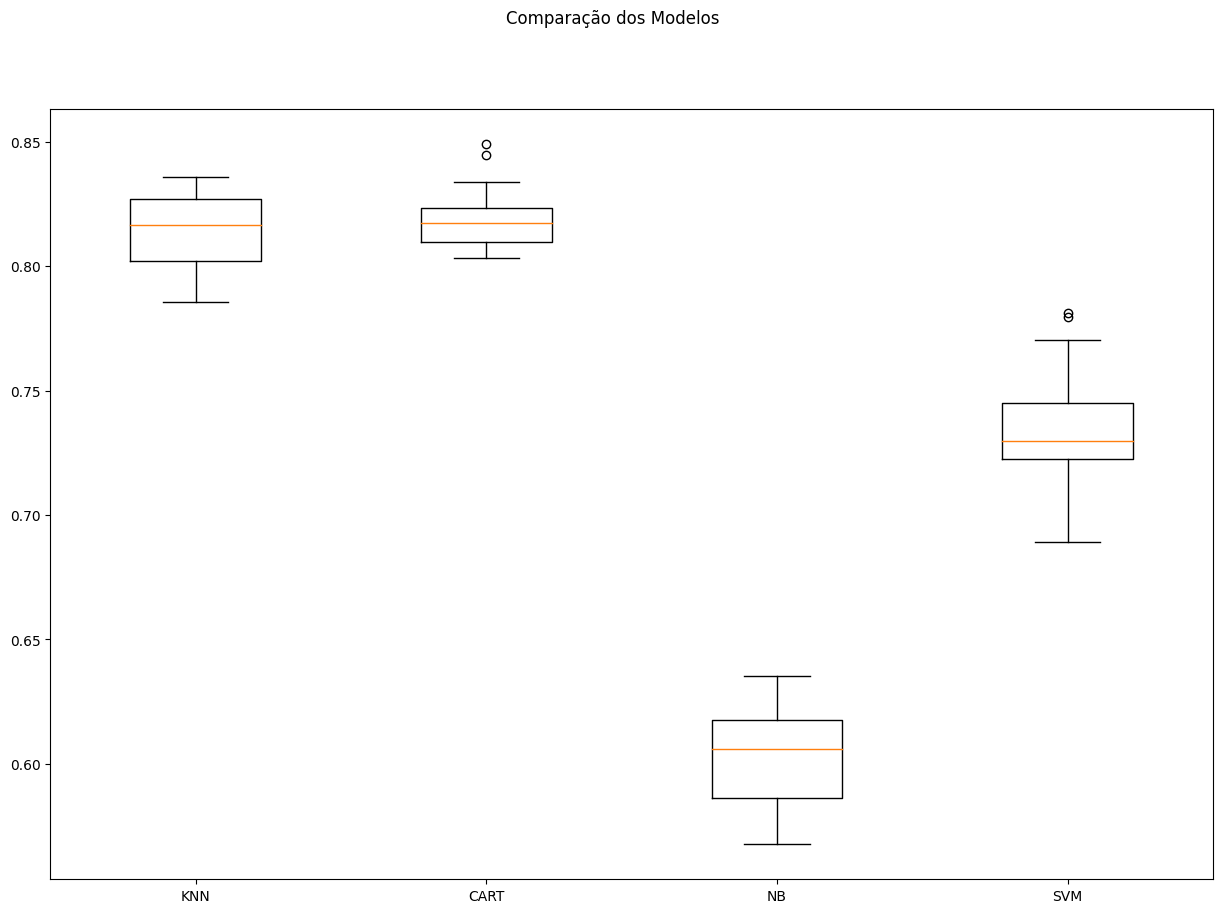

In [6]:
np.random.seed(7) # definindo uma semente global

# Lista que armazenará os modelos
models = []

# Criando os modelos e adicionando-os na lista de modelos
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC()))

# Listas para armazenar os resultados
results = []
names = []

# Avaliação dos modelos
for name, model in models:
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

# Boxplot de comparação dos modelos
fig = plt.figure(figsize=(15,10))
fig.suptitle('Comparação dos Modelos')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

## Padronização e normalização dos dados

São criados pipelines para treinar cada modelo de uma vez, com dados padronizados e outra com dados normalizados em busca de um melhor desempenho.

No final, os dados são plotados em um gráfico de comparação.

Nesta etapa o algorítimo que atingiu o melhor resultado foi o KNN com dados padronizados:
- KNN-padr: 0.838 (0.012)

KNN-orig: 0.814 (0.016)
CART-orig: 0.820 (0.012)
NB-orig: 0.603 (0.019)
SVM-orig: 0.734 (0.024)
KNN-padr: 0.838 (0.012)
CART-padr: 0.818 (0.013)
NB-padr: 0.580 (0.017)
SVM-padr: 0.814 (0.015)
KNN-norm: 0.834 (0.015)
CART-norm: 0.819 (0.013)
NB-norm: 0.590 (0.019)
SVM-norm: 0.799 (0.016)
Best acc: 0.8379279619313349


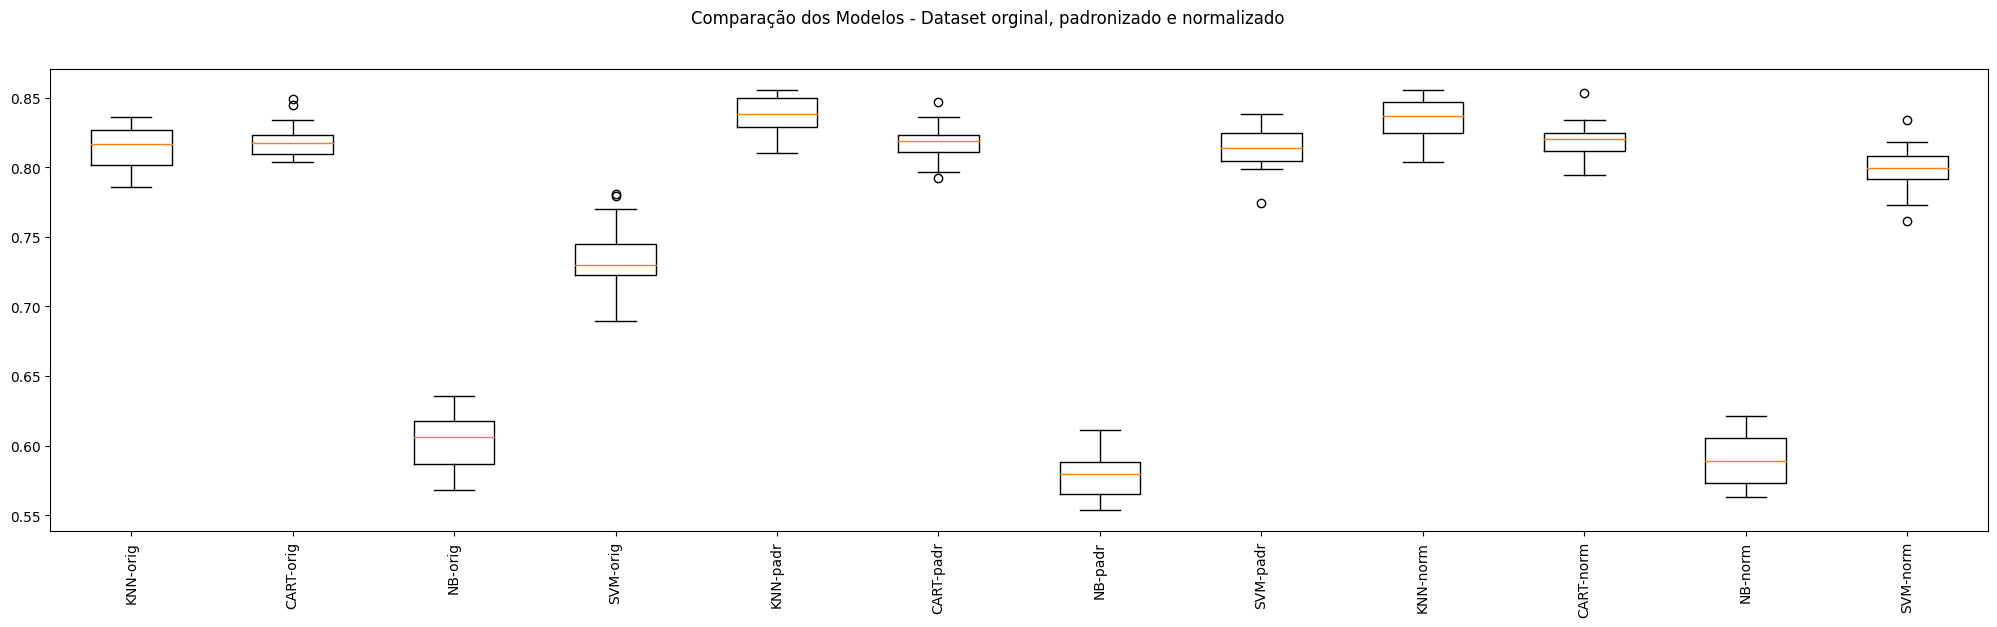

In [7]:
np.random.seed(7) # definindo uma semente global para este bloco

# Listas para armazenar os armazenar os pipelines e os resultados para todas as visões do dataset
pipelines = []
results = []
names = []


# Criando os elementos do pipeline

# Algoritmos que serão utilizados
knn = ('KNN', KNeighborsClassifier())
cart = ('CART', DecisionTreeClassifier())
naive_bayes = ('NB', GaussianNB())
svm = ('SVM', SVC())

# Transformações que serão utilizadas
standard_scaler = ('StandardScaler', StandardScaler())
min_max_scaler = ('MinMaxScaler', MinMaxScaler())


# Montando os pipelines

# Dataset original
pipelines.append(('KNN-orig', Pipeline([knn])))
pipelines.append(('CART-orig', Pipeline([cart])))
pipelines.append(('NB-orig', Pipeline([naive_bayes])))
pipelines.append(('SVM-orig', Pipeline([svm])))

# Dataset Padronizado
pipelines.append(('KNN-padr', Pipeline([standard_scaler, knn])))
pipelines.append(('CART-padr', Pipeline([standard_scaler, cart])))
pipelines.append(('NB-padr', Pipeline([standard_scaler, naive_bayes])))
pipelines.append(('SVM-padr', Pipeline([standard_scaler, svm])))

# Dataset Normalizado
pipelines.append(('KNN-norm', Pipeline([min_max_scaler, knn])))
pipelines.append(('CART-norm', Pipeline([min_max_scaler, cart])))
pipelines.append(('NB-norm', Pipeline([min_max_scaler, naive_bayes])))
pipelines.append(('SVM-norm', Pipeline([min_max_scaler, svm])))

# Executando os pipelines
for name, model in pipelines:
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %.3f (%.3f)" % (name, cv_results.mean(), cv_results.std()) # formatando para 3 casas decimais
    print(msg)

def acc_scores(result):
  return result.mean()

# Print do melhor resultado de acc
results_acc = list(map(acc_scores, results))
max_result_acc = max(results_acc)
print(f"Best acc: {max_result_acc}")

# Boxplot de comparação dos modelos
fig = plt.figure(figsize=(25,6))
fig.suptitle('Comparação dos Modelos - Dataset orginal, padronizado e normalizado')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names, rotation=90)
plt.show()

## Otimização dos hiperparâmetros

O KNN com dados padronizados foi selecionado como melhor algorítimo para esse problema.

São criados pipelines para testar o KNN com diferentes parâmetros com o método GridSearchCV que faz um grid search para encontrar a melhor combinação de hiperparâmetros do modelo.

Nesta etapa o algorítimo que atingiu o melhor resultado foi o KNN com dados padronizados, com o cálculo de distância entre os pontos utilizando a distância de Manhattan e considerando os 13 pontos mais próximos.

- knn-padr 0.839681 usando {'KNN__metric': 'manhattan', 'KNN__n_neighbors': 13}

In [8]:
# Tuning do KNN

np.random.seed(7) # definindo uma semente global para este bloco

pipelines = []

# Definindo os componentes do pipeline
knn = ('KNN', KNeighborsClassifier())

standard_scaler = ('StandardScaler', StandardScaler())
min_max_scaler = ('MinMaxScaler', MinMaxScaler())

pipelines.append(('knn-orig', Pipeline(steps=[knn])))
pipelines.append(('knn-padr', Pipeline(steps=[standard_scaler, knn])))
pipelines.append(('knn-norm', Pipeline(steps=[min_max_scaler, knn])))


param_grid = {
    'KNN__n_neighbors': [3,5,7,9,11,13,15],
    'KNN__metric': ["euclidean", "manhattan", "minkowski"],
}

# Prepara e executa o GridSearchCV
for name, model in pipelines:
    grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
    grid.fit(X_train, y_train)
    # imprime a melhor configuração
    print("Modelo: %s - Melhor: %f usando %s" % (name, grid.best_score_, grid.best_params_))

Modelo: knn-orig - Melhor: 0.818023 usando {'KNN__metric': 'manhattan', 'KNN__n_neighbors': 11}
Modelo: knn-padr - Melhor: 0.839681 usando {'KNN__metric': 'manhattan', 'KNN__n_neighbors': 13}
Modelo: knn-norm - Melhor: 0.839680 usando {'KNN__metric': 'manhattan', 'KNN__n_neighbors': 9}


## Testando o modelo com o conjunto de teste

Teste do modelo escolhido com os dados de teste utilizando um pipeline para evitar data leakage.

Nesta etapa o modelo teve um resultado levemente pior que no treino.

- 0.821084864391951

In [11]:
# Avaliação do modelo com o conjunto de testes

# model = Modelo: knn-padr - Melhor: 0.839681 usando {'KNN__metric': 'manhattan', 'KNN__n_neighbors': 13}
knn_model = KNeighborsClassifier()

# Criação do pipeline com Knn e escala padrão
pipe_knn = Pipeline([('scaler', StandardScaler()), ('KNN', knn_model)])
pipe_knn.set_params(KNN__metric='euclidean', KNN__n_neighbors=13)

# An estimator's parameter can be set using '__' syntax
pipe_knn.fit(X_train, y_train).score(X_test, y_test)

0.821084864391951

## Preparação do modelo final

O modelo escolhido é treinado com todo o dataset

In [14]:
# Preparação do modelo com TODO o dataset
pipe_knn.fit(X, y)

Pipeline(steps=[('scaler', StandardScaler()),
                ('KNN',
                 KNeighborsClassifier(metric='euclidean', n_neighbors=13))])

## Teste do modelo com dados novos dados

O modelo final é exposto a dados ainda não vistos.

Nesta etapa o resultado foi ainda menor, mas considerando que está acima de 50% e o dataset foi pequeno ainda é aceitável.

- Acurácia: 0.6666



In [17]:
data = {
         # [legitimate", legitimate", legitimate", "phishing", legitimate", "phishing"]
         "length_url": [28, 88, 22, 61, 29, 60],
         "length_hostname": [19, 20, 15, 15, 20, 16],
         "nb_dots": [2, 3, 1, 2, 2, 2],
         "nb_hyphens": [0, 5, 0, 0, 0, 0],
         "nb_underscore": [0, 0, 0, 2, 0, 0],
         "nb_tilde": [0, 0, 0, 0, 0, 0],
         "nb_percent": [0, 0, 0, 0, 0, 0],
         "nb_slash": [3, 5, 2, 4, 3, 5],
         "nb_colon": [1, 1, 1, 1, 1, 1],
         "nb_comma": [0, 0, 0, 0, 0, 0],
         "nb_semicolumn": [0, 0, 0, 0, 0, 0],
         "nb_dollar": [0, 0, 0, 0, 0, 0],
         "nb_space": [0, 0, 0, 0, 0, 0],
         "nb_www": [1, 1, 0, 1, 0, 0],
         "nb_com": [0, 0, 0, 0, 0, 0],
         "http_in_path": [0, 0, 0, 0, 0, 0],
     }

atributos = list(data.keys())

entrada = pd.DataFrame(data, columns=atributos)

# Previsão do modelo knn com novos dados
saidas_pipe_knn = pipe_knn.predict(entrada)
y_pred = saidas_pipe_knn
y_true = ["legitimate", "legitimate", "legitimate", "phishing", "legitimate", "phishing"]
target_names = ["legitimate", "phishing"]
print(classification_report(y_true, y_pred, target_names=target_names))
print(f"Acurácia: {accuracy_score(y_true, y_pred)}")


              precision    recall  f1-score   support

  legitimate       0.75      0.75      0.75         4
    phishing       0.50      0.50      0.50         2

    accuracy                           0.67         6
   macro avg       0.62      0.62      0.62         6
weighted avg       0.67      0.67      0.67         6

Acurácia: 0.6666666666666666


## Salva o modelo no disco

O modelo é exportado no formato joblib para ser usado no back-end

In [18]:

pipe_file = 'pipe_knn__url_checker.joblib'
joblib.dump(pipe_knn, open(pipe_file, 'wb'))

## Conclusão

O modelo apresentou resultados bons com os dados de treinamento e teste, mas quando foi exposto a dados não vistos teve uma queda, ainda sim, seu desempenho foi satisfatório.

Para melhorar o desempenho, acredito que:

- Aumentar o dataset de treino melhoraria a acurácia do modelo.
- Aumentar o número de parâmetros a serem analisados pelo modelo aumentaria a probabilidade dele avaliar corretamente um URL.
- Aumentar o dataset de dados não vistos para diminuir a penalização de uma predição errada melhoraria a acurácia do teste.